In [2]:
import sys
sys.path.insert(0, '../../utils/')

In [3]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import minmax_scale
from matplotlib import cm

%matplotlib inline
mpl.rcParams['figure.dpi']= 500
sns.set_context("notebook")
sns.set(style="white")
plt.rcParams['font.family'] = 'Myriad Pro'

In [4]:
from cellvgae import mean_of_attention_heads

In [5]:
LATENT_DIM = 50
ATTN_HEADS = 10

In [6]:
cellvgae_node_embs = np.load('Darmanis/CellVGAE/cellvgae_node_embs.npy')
cellvgae_umap = np.load('Darmanis/CellVGAE/cellvgae_umap.npy')
cellvgae_clusters = np.load('Darmanis/CellVGAE/cellvgae_clusters.npy')

In [7]:
layer_1_attn_edge_index = torch.load('Darmanis/attn_layers_data/darmanis_hidden_layer_1_attention_edge_index.pt')
layer_1_attn_coeff = torch.load('Darmanis/attn_layers_data/darmanis_hidden_layer_1_attention_coeff.pt')

In [8]:
layer_2_attn_edge_index = torch.load('Darmanis/attn_layers_data/darmanis_hidden_layer_2_attention_edge_index.pt')
layer_2_attn_coeff = torch.load('Darmanis/attn_layers_data/darmanis_hidden_layer_2_attention_coeff.pt')

In [9]:
layer_mean_attn_edge_index = torch.load('Darmanis/attn_layers_data/darmanis_hidden_layer_mean_attention_edge_index.pt')
layer_mean_attn_coeff = torch.load('Darmanis/attn_layers_data/darmanis_hidden_layer_mean_attention_coeff.pt')

In [10]:
layer_std_attn_edge_index = torch.load('Darmanis/attn_layers_data/darmanis_hidden_layer_std_attention_edge_index.pt')
layer_std_attn_coeff = torch.load('Darmanis/attn_layers_data/darmanis_hidden_layer_std_attention_coeff.pt')

In [11]:
darmanis_df = pd.read_csv('Darmanis/darmanis_ground_truth_clusters.csv')

In [12]:
cell_types = darmanis_df['Cluster'].values.tolist()

In [13]:
num_cells = len(cell_types)

In [14]:
def get_cell_weights_for_layer(layer_edge_index, layer_coeff):
    cell_weights = []
    for dim in range(0, ATTN_HEADS):
        cell_weights_dim = []
        for cell_id in range(num_cells):
            dim0 = layer_edge_index[0] == cell_id
            dim1 = layer_edge_index[1] == cell_id
            idxs = torch.logical_or(dim0, dim1)
            cell_weight = torch.sum(layer_coeff[idxs, dim])
            cell_weights_dim.append(cell_weight.detach().numpy())
        cell_weights.append(cell_weights_dim)
    return np.array(cell_weights)

In [17]:
mean_layer_cell_weights = get_cell_weights_for_layer(layer_mean_attn_edge_index, layer_mean_attn_coeff)
std_layer_cell_weights = get_cell_weights_for_layer(layer_std_attn_edge_index, layer_std_attn_coeff)
second_layer_cell_weights = get_cell_weights_for_layer(layer_2_attn_edge_index, layer_2_attn_coeff)
first_layer_cell_weights = get_cell_weights_for_layer(layer_1_attn_edge_index, layer_1_attn_coeff)

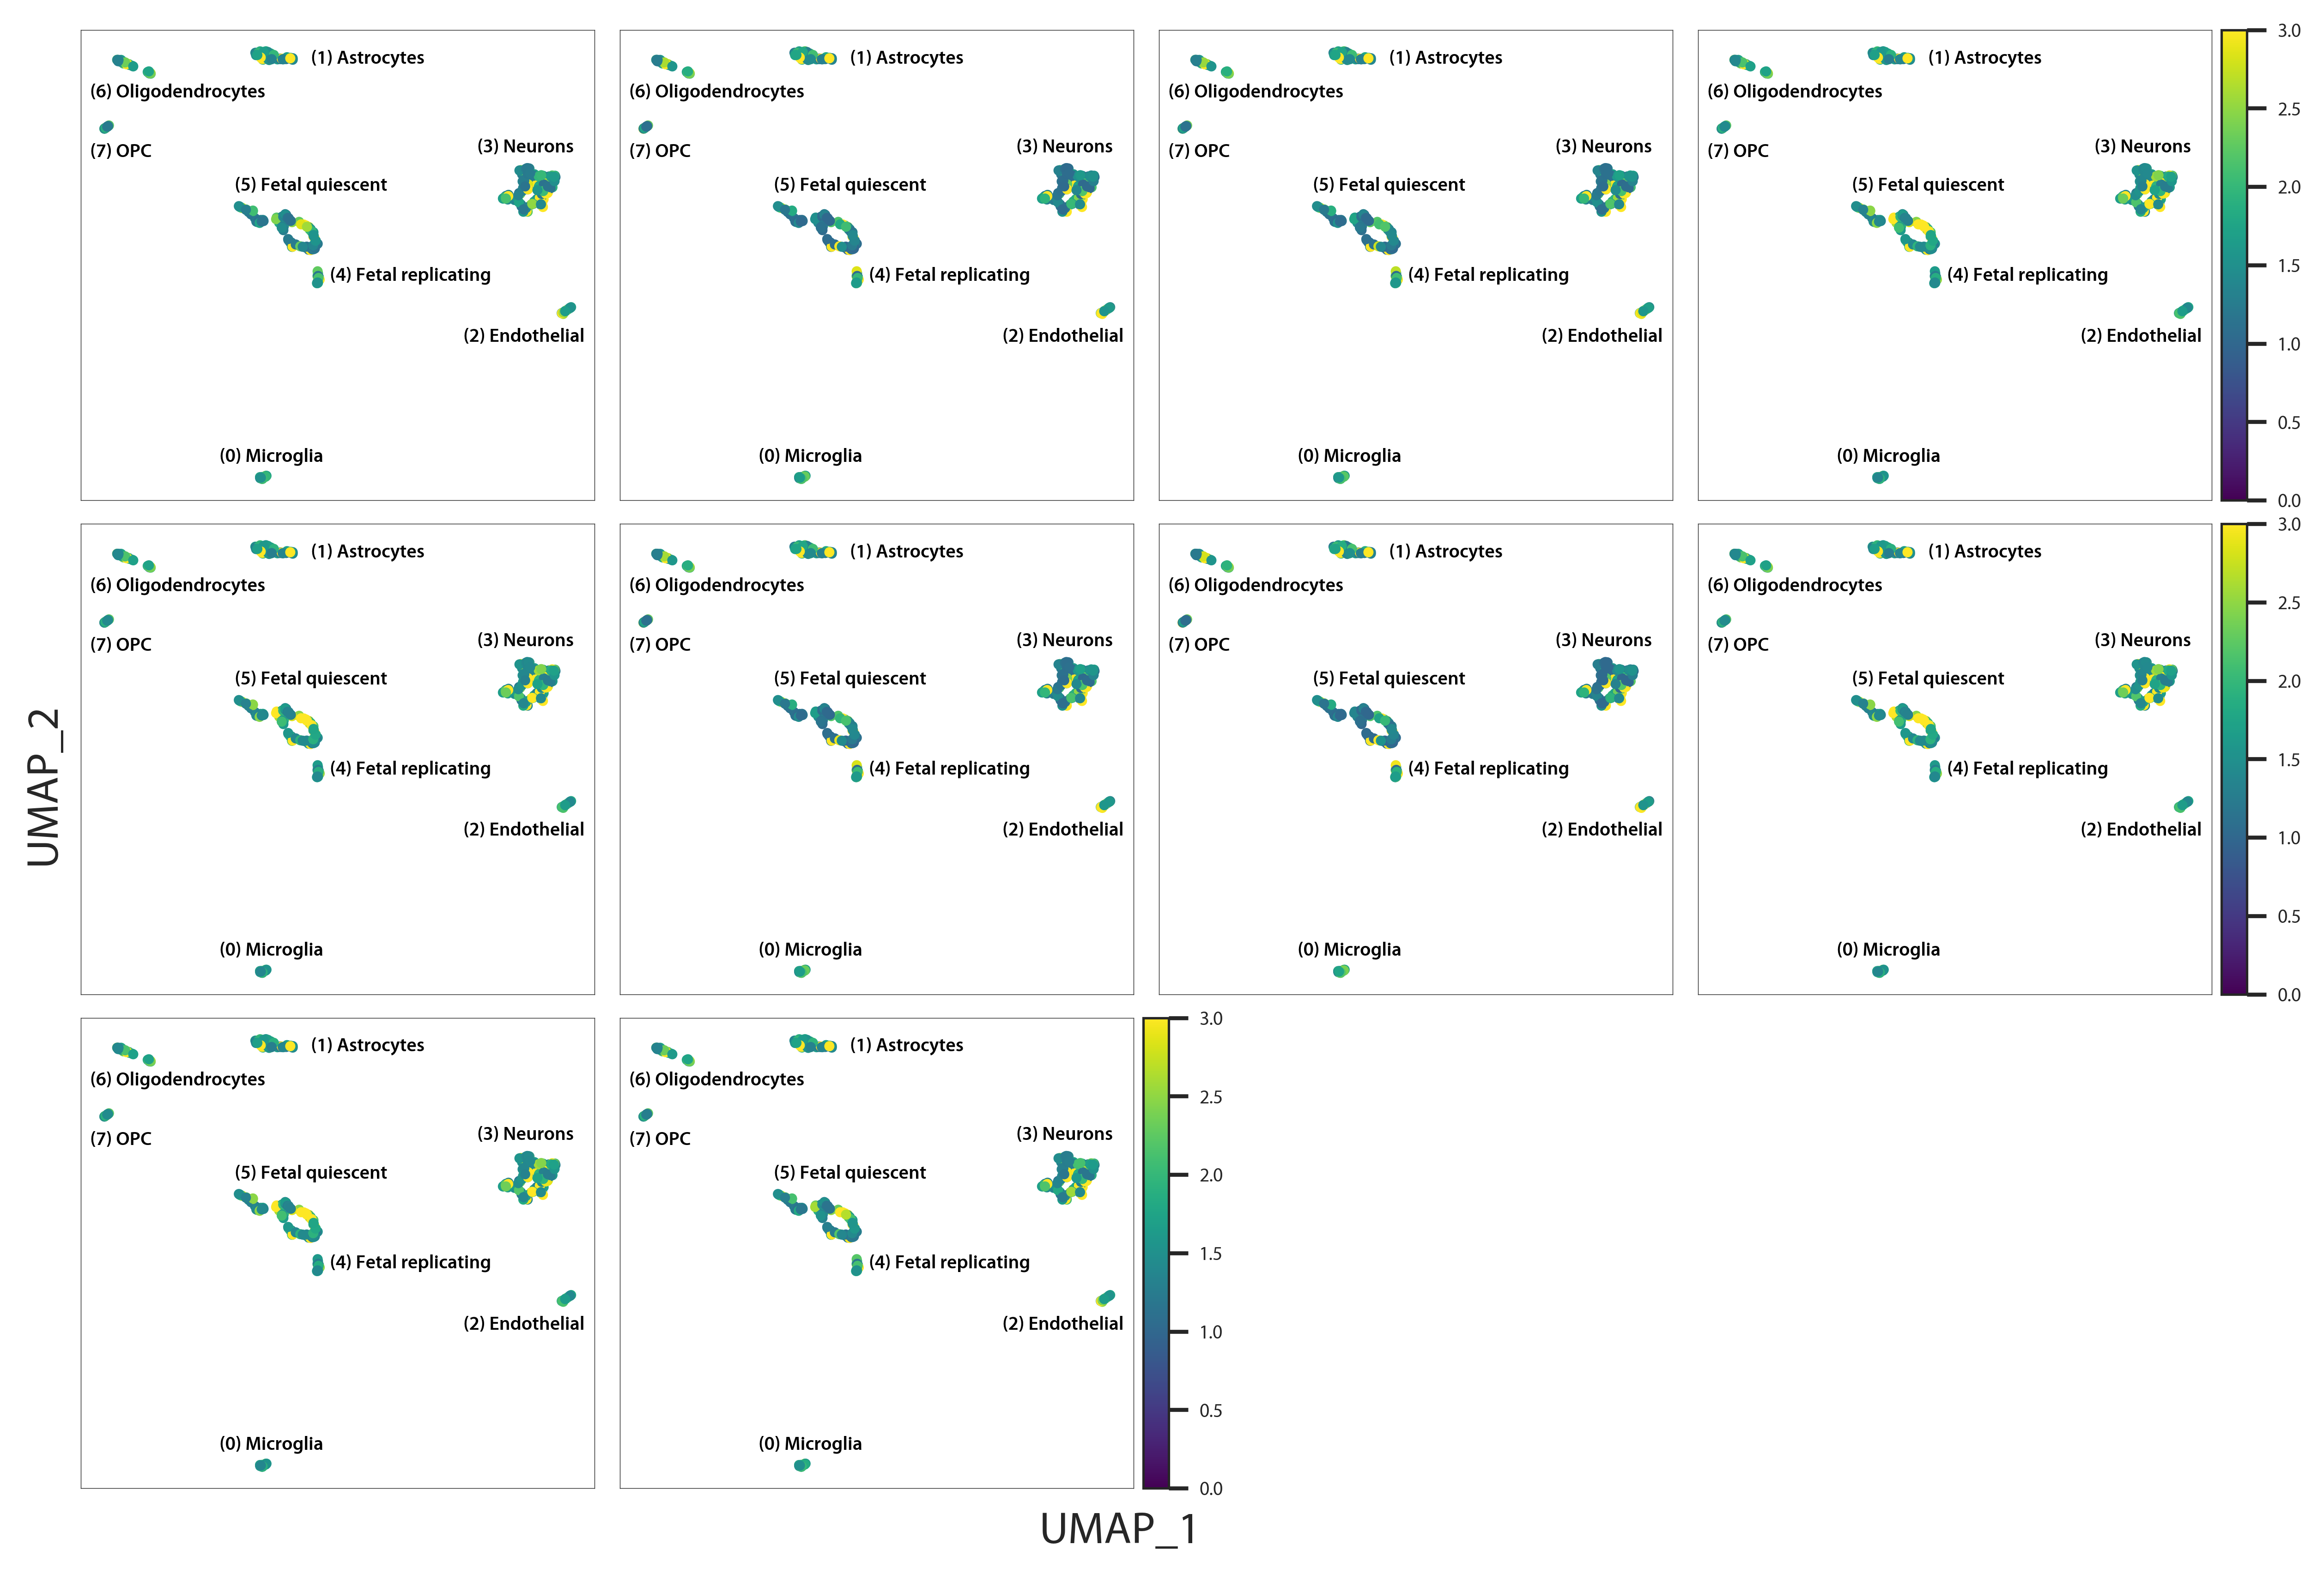

In [94]:
fig, axes = plt.subplots(3, 4, figsize=(10, 7))
fig.tight_layout()

for i in range(3):
    for j in range(4):
        if i == 2 and j > 1:
            ax = axes[i][j]
            ax.axis('off')
        else:
            ax = axes[i][j]
            sns.scatterplot(x=cellvgae_umap[:, 0], y=cellvgae_umap[:, 1], hue=std_layer_cell_weights[i * 3 + j, :], hue_norm=(0, 3), palette='viridis', s=10, edgecolor='black', linewidth=0.0, ax=ax)
            ax.get_legend().remove()

            if (j == 3) or (i == 2 and j == 1):
                axins = inset_axes(ax,
                        width='5%',  
                        height='100%',
                        loc='center right',
                        borderpad=-1
                       )
                norm = plt.Normalize(0, 3)
                sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
                sm.set_array([])
                cbar = fig.colorbar(sm, ax=ax, cax=axins, pad=0.2)
                cbar.ax.tick_params(labelsize=6)
                cbar.outline.set_linewidth(0.75)

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.spines['left'].set_linewidth(0.2)
            ax.spines['top'].set_linewidth(0.2)
            ax.spines['bottom'].set_linewidth(0.2)
            ax.spines['right'].set_linewidth(0.2)

            ax.text(-1.5, -22.5, "(0) Microglia", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(4.5, 15.75, "(1) Astrocytes", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(14.5, -11, "(2) Endothelial", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(15.4, 7.2, "(3) Neurons", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(5.75, -5.1, "(4) Fetal replicating", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(-0.5, 3.5, "(5) Fetal quiescent", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(-10, 12.5, "(6) Oligodendrocytes", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(-10, 6.75, "(7) OPC", horizontalalignment='left', size='6', color='black', weight='semibold')
        
fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.supxlabel('UMAP_1', fontsize=14, y=0.025)
fig.supylabel('UMAP_2', fontsize=14, x=0.025)
plt.savefig('darmanis_umap_layer_sigma.pdf', dpi=350, bbox_inches = 'tight')

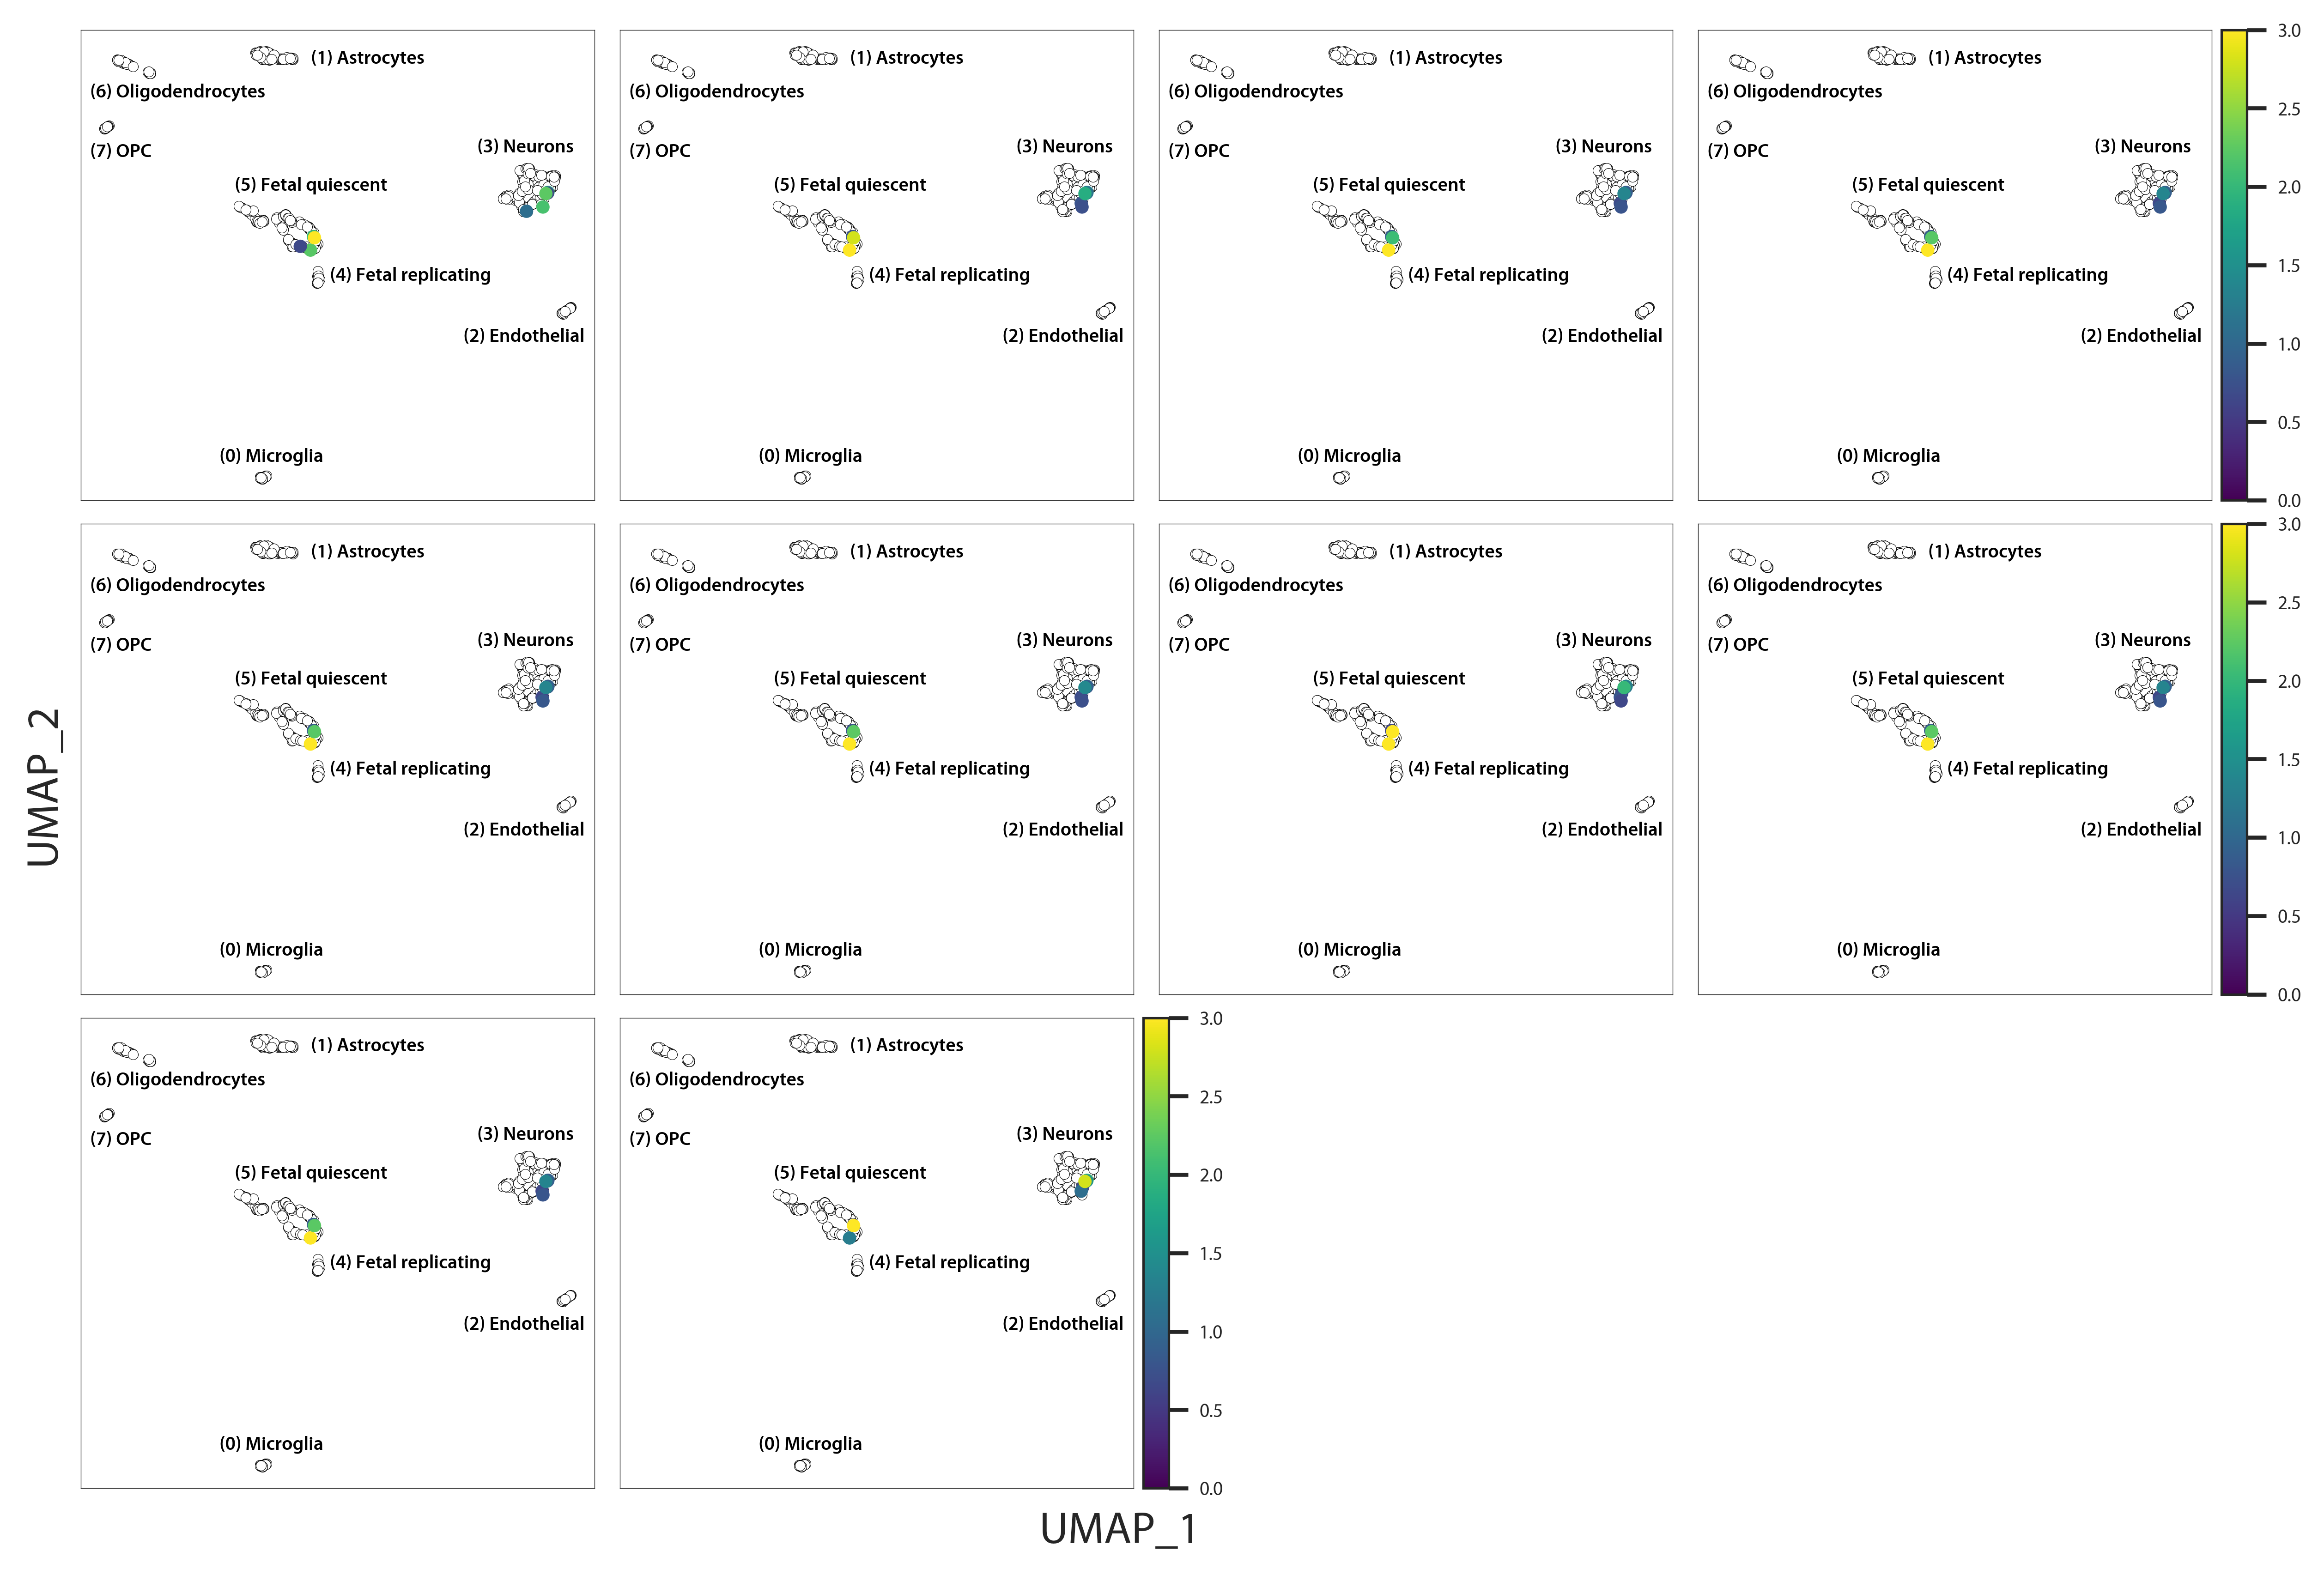

In [100]:
viridis = cm.get_cmap('viridis')
fig, axes = plt.subplots(3, 4, figsize=(10, 7))
fig.tight_layout()

for i in range(3):
    for j in range(4):
        if i == 2 and j > 1:
            ax = axes[i][j]
            ax.axis('off')
        else:
            ax = axes[i][j]
            
            diff = np.abs(std_layer_cell_weights[i * 3 + j, :] - np.mean(std_layer_cell_weights, axis=0))
            norm = plt.Normalize()
            diff_scaled = norm(diff)
            colors = viridis(diff_scaled)

            idx_zero = np.where(diff_scaled < 0.2)
            idx_one = np.where(diff_scaled >= 0.2)
        
            ax.scatter(x=cellvgae_umap[idx_zero[0], 0], y=cellvgae_umap[idx_zero[0], 1], s=10, c='#ffffff', linewidths=0.15, edgecolors='#000000')
            ax.scatter(x=cellvgae_umap[idx_one[0], 0], y=cellvgae_umap[idx_one[0], 1], s=10, c=colors[idx_one[0]])

            if (j == 3) or (i == 2 and j == 1):
                axins = inset_axes(ax,
                        width='5%',  
                        height='100%',
                        loc='center right',
                        borderpad=-1
                       )
                norm = plt.Normalize(0, 3)
                sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
                sm.set_array([])
                cbar = fig.colorbar(sm, ax=ax, cax=axins, pad=0.2)
                cbar.ax.tick_params(labelsize=6)
                cbar.outline.set_linewidth(0.75)

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.spines['left'].set_linewidth(0.2)
            ax.spines['top'].set_linewidth(0.2)
            ax.spines['bottom'].set_linewidth(0.2)
            ax.spines['right'].set_linewidth(0.2)

            ax.text(-1.5, -22.5, "(0) Microglia", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(4.5, 15.75, "(1) Astrocytes", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(14.5, -11, "(2) Endothelial", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(15.4, 7.2, "(3) Neurons", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(5.75, -5.1, "(4) Fetal replicating", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(-0.5, 3.5, "(5) Fetal quiescent", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(-10, 12.5, "(6) Oligodendrocytes", horizontalalignment='left', size='6', color='black', weight='semibold')
            ax.text(-10, 6.75, "(7) OPC", horizontalalignment='left', size='6', color='black', weight='semibold')
        
fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.supxlabel('UMAP_1', fontsize=14, y=0.025)
fig.supylabel('UMAP_2', fontsize=14, x=0.025)
plt.savefig('darmanis_umap_layer_sigma_DIFF.pdf', dpi=350, bbox_inches = 'tight')